# Analyse Histogramme

In [15]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

## Comparaison des images moyennes
Création d'une nouvelle image pour les dossiers Data/Mer et Data/Ailleurs représentant la moyenne de toutes les images pixel par pixel


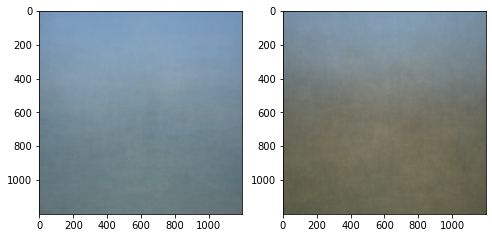

In [16]:
def average_img(imlist):
    # source : https://stackoverflow.com/questions/17291455/how-to-get-an-average-picture-from-100-pictures-using-pil
    images = np.array([np.array(Image.open(fname).resize((1200, 1200)).convert("RGB")) for fname in imlist])
    arr = np.array(np.mean(images, axis=(0)), dtype=np.uint8)
    out = Image.fromarray(arr)
    return out

fig = plt.figure(figsize=(8, 8))
fig.add_subplot((121))
imlist = ["./Data/Mer/" + fname for fname in os.listdir("./Data/Mer/")][:]
plt.imshow(average_img(imlist))
fig.add_subplot((122))
imlist = ["./Data/Ailleurs/" + fname for fname in os.listdir("./Data/Ailleurs/")][:]
plt.imshow(average_img(imlist));

On peut voir ici que les différences se trouvent principalement dans les deux tiers inférieurs de l'image
Pour la suite de notre analyse de l'histogramme, nous allons donc nous intéresser à cette partie des images

## Comparaison des histogrammes moyens

In [17]:
def average_histogram(directory):
    r_sum = 0
    g_sum = 0
    b_sum = 0
    for file in tqdm(os.listdir(directory)):
        image = Image.open(directory + "/" + file)
        image = image.convert("RGB")
        image = image.resize((500,750))
        image = image.crop((0, 250, 500, 750)) # suppression du tiers haut de l'image
        r, g, b = image.split()
        r_sum += np.array(r.histogram())
        g_sum += np.array(g.histogram())
        b_sum += np.array(b.histogram())
    nb_files = len(os.listdir(directory))
    r_avg = r_sum / nb_files
    g_avg = g_sum / nb_files
    b_avg = b_sum / nb_files
    return r_avg, g_avg, b_avg

100%|██████████| 249/249 [00:03<00:00, 62.30it/s]


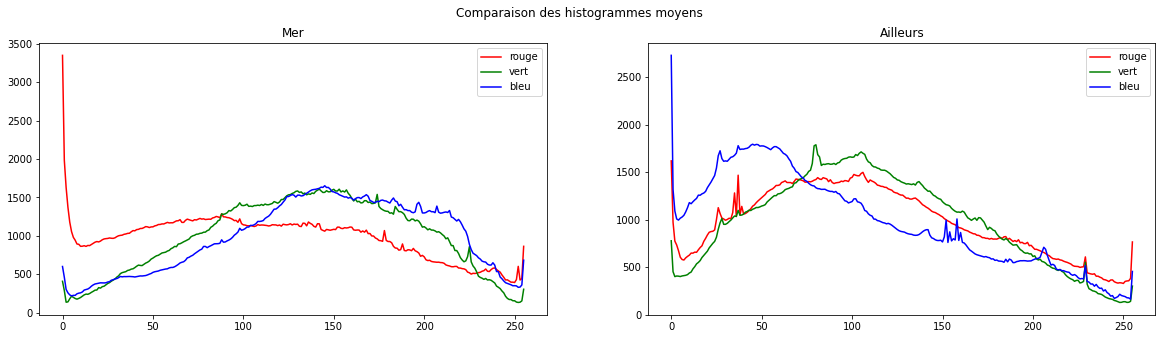

In [18]:
r_sea, g_sea, b_sea = average_histogram("./Data/Mer")
r_other, g_other, b_other = average_histogram("./Data/Ailleurs")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
fig.suptitle('Comparaison des histogrammes moyens')

ax1.set_title("Mer")
ax1.plot(r_sea, '-r', label="rouge")
ax1.plot(g_sea, '-g', label="vert")
ax1.plot(b_sea, '-b', label="bleu")

ax1.legend()

ax2.set_title("Ailleurs")
ax2.plot(r_other, '-r', label="rouge")
ax2.plot(g_other, '-g', label="vert")
ax2.plot(b_other, '-b', label="bleu")

ax2.legend();

Les niveaux de bleu sont en moyenne plus élevés dans les images de mer, nous allons donc représenter les données
par leurs histogrammes de bleu

## Préparation des données

In [19]:
def compute_data(X, y, directory, elementsClass):
    for file in tqdm(os.listdir(directory)):
        image = Image.open(directory + "/" + file)
        image = image.convert("RGB")
        image = image.resize((500,750))
        image = image.crop((0, 250, 500, 750))
        r, g, b = image.split()
        X.append(b.histogram())
        y.append(elementsClass)

In [20]:
X = []
y = []

compute_data(X, y, "./Data/Ailleurs", 0)
compute_data(X, y, "./Data/Mer", 1)


from sklearn.preprocessing import Normalizer

transformer = Normalizer()
X = transformer.transform(X)

100%|██████████| 246/246 [00:03<00:00, 70.99it/s]


## Apprentissage

In [21]:
def plot_results(clf_scores):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
    fig.suptitle('Résultats')
    ax1.hist(clf_scores)
    ax2.boxplot(clf_scores)

    print("Moyenne : " + str(np.mean(clf_scores))+  ", Variance : " + str(np.var(clf_scores)) + ", Écart-type : " + str(np.std(clf_scores)))

Moyenne : 0.7639393939393938, Variance : 0.0011134680134680136, Écart-type : 0.033368668140457955


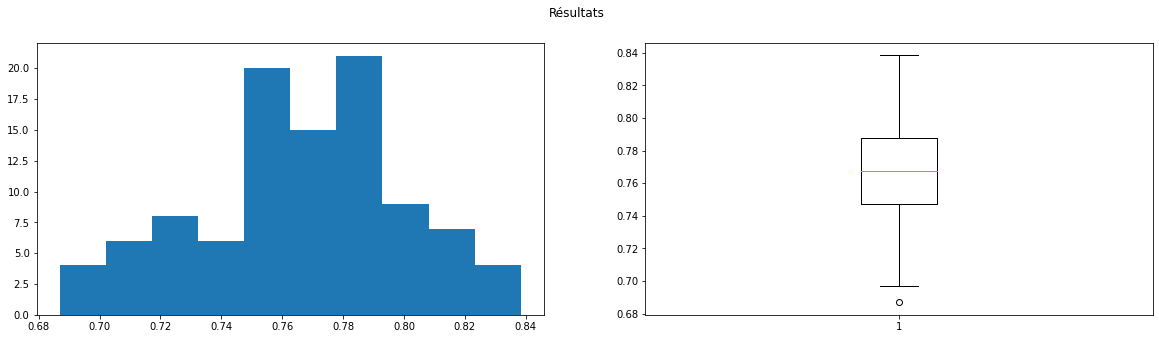

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

classifieur = GaussianNB()

nb_runs = 100
clf_scores = []
for i in range(nb_runs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    classifieur.fit(X_train, y_train)
    y_predits = classifieur.predict(X_test)
    clf_scores.append(accuracy_score(y_test, y_predits))
plot_results(clf_scores)

100%|██████████| 100/100 [00:30<00:00,  3.23it/s]


Moyenne : 0.7734343434343436, Variance : 0.0011983573104785228, Écart-type : 0.03461729785061975


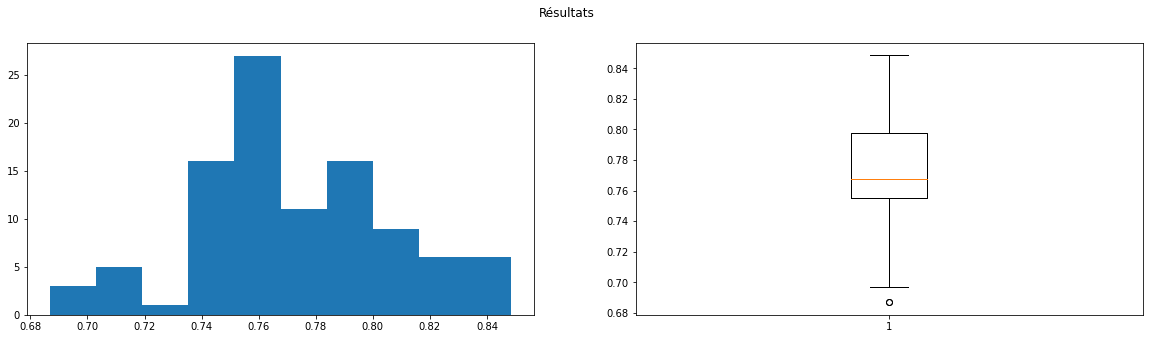

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

classifieur = RandomForestClassifier(max_depth=5, min_samples_split=5)

nb_runs = 100
clf_scores = []
for i in tqdm(range(nb_runs)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    classifieur.fit(X_train, y_train)
    y_predits = classifieur.predict(X_test)
    clf_scores.append(accuracy_score(y_test, y_predits))
plot_results(clf_scores)

## Export

In [24]:
classifieur.fit(X,y)
from joblib import dump
dump(classifieur, 'histogram.joblib')

['histogram.joblib']